In [1]:
from IPython.core.display import HTML

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
from scipy.integrate import odeint, trapz
from IPython.display import HTML

from scipy.fft import fft, ifft
matplotlib.rcParams.update({'font.size': 14})


# 1.a Pseudospectral method

based on the code in:´

https://www.youtube.com/watch?v=rsdqvrldgHM&list=WL&index=181

To do:

- define L in terms of Re not the other way around
- Write own procedure to solve the differential equation because built in libraries cannot account to the 
  changing of the fields.


In [3]:
def diffusion_q(q,t,w_x,nx,l):
    # pseudospectral differential equation
    
    # args-> q :array, the propagator to solve
    #        t: vector, represents the polymer contour 
    #       wx: array, the external field
    #       nx: scalar, number of x points
    #       l: scalar, length of the system
    
    # coeffient for the second derivative
    a = ((l/2.0)**2)/6
    # n that indexes the fourier modes
    n = np.fft.fftfreq(nx)*nx*2*np.pi/l

    return a *ifft(((2*np.pi*1j*n/l)**2)*fft(q)).real - w_x*q

def diffusion_q_dagger(q,t,w_x,nx,l):
    # pseudospectral differential equation
    
    # args-> q :array, the propagator to solve
    #        t: vector, represents the polymer contour 
    #       wx: array, the external field
    #       nx: scalar, number of x points
    #       l: scalar, length of the system
    
    # coeffient for the second derivative
    a = ((l/2.0)**2)/6
    # n that indexes the fourier modes
    n = np.fft.fftfreq(nx)*nx*2*np.pi/l

    return - a * ifft(((2*np.pi*1j*n/l)**2*fft(q))).real + w_x*q


In [317]:
# length of the system
Re = 1.0
L = 2*Re
# number of points in space 
Nx = 256
# number of beads in the polymer contour
N = 64
# spatial discretization 
x = np.linspace(0,Nx, Nx)
x[:Nx] = x[:Nx]*L/Nx
# periodic boundaries
x[-1] = x[0]
# polymer contour
s = np.linspace(0,1,N)
# cutting point of the polymer diving A and B
f = 1/2

# fields  used for the differential equation
wa = 5*np.cos(2*np.pi*x/L)
wb = -wa

# initial conditions
q0 = q0_dag = np.ones(Nx)


In [318]:
# first half of the polymer start from the first bead
q_1 = odeint(diffusion_q, q0, s[:int(N*f)], args=(wa,Nx,L))
# second half of the polymer 
q_2 = odeint(diffusion_q, q_1[-1], s[int(N*f):], args=(wb,Nx,L))
q = np.concatenate((q_1,q_2),axis=0)

# for the transposed q start from the last bead 
qdag_1 = odeint(diffusion_q_dagger, q0_dag, np.flip(s[int(N*f):]), args=(wb,Nx,L))
qdag_2 = odeint(diffusion_q_dagger, qdag_1[-1], np.flip(s[:int(N*f)]), args=(wa,Nx,L))
q_dag = np.concatenate((qdag_1,qdag_2),axis=0)
q_dag = np.flip(q_dag)


Calculate the single chain partition function to make sure that propagators are correct. This partition function should be constant across all 's'

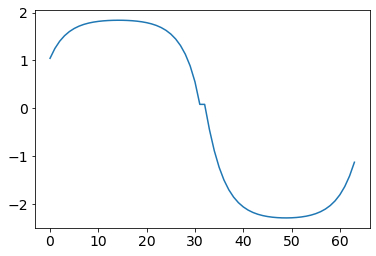

In [319]:
Q_Q0 = trapz(q*q_dag, x,axis=1)
plt.plot(Q_Q0)

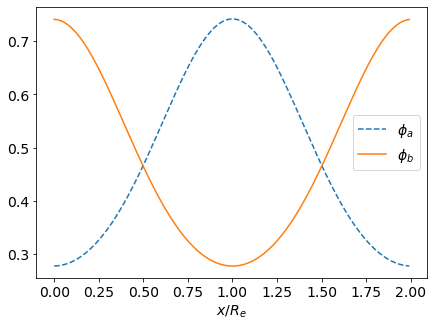

In [320]:
prod_q = q*q_dag
phi_a = (1/np.max(Q_Q0))*trapz(prod_q[:int(len(s)*f)], s[:int(len(s)*f)],axis=0)
phi_b = (1/np.max(Q_Q0))*trapz(prod_q[int(len(s)*f):], s[int(len(s)*f):],axis=0)

plt.figure(figsize=(7,5))
plt.plot(x[:-1], phi_a[:-1], label='$\phi_a$',linestyle='dashed')
plt.plot(x[:-1], phi_b[:-1],label='$\phi_b$')
plt.xlabel(r'$x/R_e$')
plt.legend()


# 2b. Picard iteration and self consistent field theory

In [11]:
def calculate_densities(re,x ,s, f ,wa, wb):
    # Calculates the densities of given wa and wb
    
    # args -> re: scalar, Re experimental paramaterer
    # x: aray, array with space position
    # s: array, position of chains
    # f: scalar, cut off point between A and B parts
    # wa: array, w field for the first half of the copolymer
    # wb: array, w field for the second half of the copolymer
    
    # returs-> phi_a, phi_b arrays representing the densities 
    
    # length of the system
    L = 2*re
    # number of space points
    nx = len(x)
    # number of beads
    n = len(s)

    # fields  used for the differential equation
    wa = 5*np.cos(2*np.pi*x/L)
    wb = -wa

    # initial conditions
    q0 = q0_dag = np.ones(nx)
    
    # first half of the polymer start from the first bead
    q_1 = odeint(diffusion_q, q0, s[:int(n*f)], args=(wa,nx,L))
    # second half of the polymer 
    q_2 = odeint(diffusion_q, q_1[-1], s[int(n*f):], args=(wb,nx,L))
    q = np.concatenate((q_1,q_2),axis=0)

    # for the transposed q start from the last bead 
    qdag_1 = odeint(diffusion_q_dagger, q0_dag, np.flip(s[int(n*f):]), args=(wb,nx,L))
    qdag_2 = odeint(diffusion_q_dagger, qdag_1[-1], np.flip(s[:int(n*f)]), args=(wa,nx,L))
    q_dag = np.concatenate((qdag_1,qdag_2),axis=0)
    q_dag = np.flip(q_dag)
    
    return q, q_dag
    

In [13]:
# length of the system
Re = 1.0
L = 2*Re
# number of points in space 
Nx = 256
# number of beads in the polymer contour
N = 64
# spatial discretization 
x = np.linspace(0,Nx, Nx)
x[:Nx] = x[:Nx]*L/Nx
# periodic boundaries
x[-1] = x[0]

# polymer contour
s = np.linspace(0,1,N )
# cutting point of the polymer diving A and B
F = 1/2

# fields  used for the differential equation
wa = 5*np.cos(2*np.pi*x/L)
wb = -wa

q, q_dag = calculate_densities(Re,x,s, F ,wa, wb)

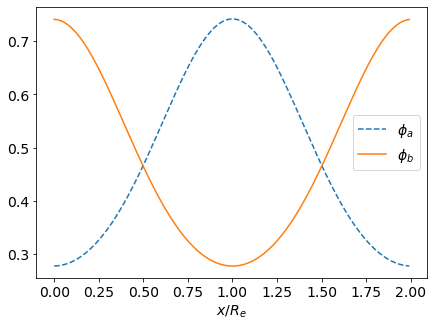

In [14]:
Q_Q0 = trapz(q*q_dag, x,axis=1)

prod_q = q*q_dag
phi_a = (1/np.max(Q_Q0))*trapz(prod_q[:int(len(s)*F)], s[:int(len(s)*F)],axis=0)
phi_b = (1/np.max(Q_Q0))*trapz(prod_q[int(len(s)*F):], s[int(len(s)*F):],axis=0)

plt.figure(figsize=(7,5))
plt.plot(x[:-1], phi_a[:-1], label='$\phi_a$',linestyle='dashed')
plt.plot(x[:-1], phi_b[:-1],label='$\phi_b$')
plt.xlabel(r'$x/R_e$')
plt.legend()

# Explicit euler method 


def get_q(nx, u0, cut_off):
    # space discrete
    # nx = Nx
    # under the same initial conditions
    int_interval = s
    # constant for the second derivative
    alpha = Re**2/6
    # cut_off = f
    w_x = wa

    #n = np.arange(nx)
    #n[int(nx/2)+1:]-= nx
    n = np.fft.fftfreq(nx)*nx*2*np.pi/L
    delta_s = int_interval[1] - int_interval[0]

    propagator = []
    propagator.append(u0)
    for i in range(0,len(int_interval)):
        if i == len(int_interval)*cut_off:
            print(i)
            wx = wb
        nex_step = np.exp(-w_x*delta_s/2 ) * ifft( np.exp( -alpha*delta_s*(2*np.pi*1j*n/L) )\
                                                  * fft( np.exp(-w_x*delta_s/2)* propagator[i]) ).real

        propagator.append(nex_step)
    
    return np.asarray(propagator)

def get_qdagger(nx, u0, cut_off):
    # space discrete
    int_interval = s
    # constant for the second derivative
    alpha = Re**2/6
    w_x = wb

    #n = np.arange(nx)
    #n[int(nx/2)+1:]-= nx
    n = np.fft.fftfreq(nx)*nx*2*np.pi/L
    delta_s = int_interval[1] - int_interval[0]

    propagator = []
    propagator.append(u0)
    for i in range(0,len(int_interval)):
        if i == len(int_interval)*cut_off:
            print(i)
            wx = wa
        nex_step = nex_step = np.exp( w_x*delta_s/2 ) * ifft( np.exp(-alpha*delta_s*(2*np.pi*1j*n/L))\
                                                             * fft( np.exp(w_x*delta_s/2)* propagator[i])).real

        propagator.append(nex_step)
    
    return np.asarray(propagator)

q = get_q(Nx, q0, f)
q_dag = get_qdagger(Nx, q0_dag, f)
q_dag = np.flip(q_dag)

def get_qdagger(nx, u0, cut_off):
    # space discrete
    int_interval = s
    # constant for the second derivative
    alpha = Re**2/6
    w_x = wb

    n = np.arange(nx)
    n[int(nx/2)+1:]-= nx
    delta_s = int_interval[1] - int_interval[0]

    propagator = []
    propagator.append(u0)
    for i in range(0,len(int_interval)):
        if i == len(int_interval)*cut_off:
            print(i)
            wx = wa
        nex_step = propagator[i] + \
                    delta_s*( - alpha * ifft((2*np.pi*1j*n/L)**2*fft(propagator[i])).real + w_x*propagator[i] )

        propagator.append(nex_step)
    
    return propagator

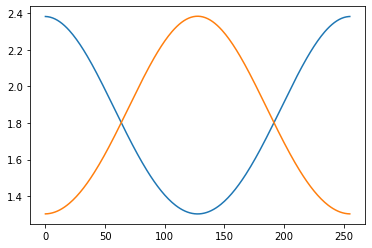

In [263]:
plt.plot(q[-1])
plt.plot(q_dag[0])

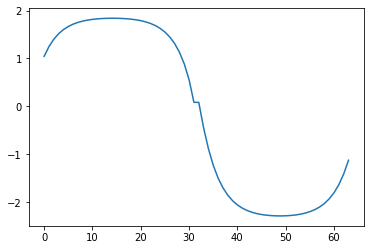

In [264]:
Q_Q0 = trapz(q*q_dag, x,axis=1)
plt.plot(Q_Q0)


In [322]:
len(np.flip(s[int(len(s)*f):]))
len(prod_q[int(len(s)*f)+1:])

31

In [323]:
prod_q = q*q_dag
phi_a = (1/np.mean(Q_Q0))*trapz(prod_q[:int(len(s)*f)], s[:int(len(s)*f)],axis=0)
phi_b = (1/np.mean(Q_Q0))*trapz(prod_q[int(len(s)*f):], s[int(len(s)*f)-1:],axis=0)

plt.plot(phi_a)
plt.plot(phi_b)

ValueError: operands could not be broadcast together with shapes (32,1) (31,256) 

In [160]:

xi = np.fft.fftfreq(Nx)*Nx*2*np.pi/L

In [144]:
xi

array([   0.        ,    3.14159265,    6.28318531,    9.42477796,
         12.56637061,   15.70796327,   18.84955592,   21.99114858,
         25.13274123,   28.27433388,   31.41592654,   34.55751919,
         37.69911184,   40.8407045 ,   43.98229715,   47.1238898 ,
         50.26548246,   53.40707511,   56.54866776,   59.69026042,
         62.83185307,   65.97344573,   69.11503838,   72.25663103,
         75.39822369,   78.53981634,   81.68140899,   84.82300165,
         87.9645943 ,   91.10618695,   94.24777961,   97.38937226,
        100.53096491,  103.67255757,  106.81415022,  109.95574288,
        113.09733553,  116.23892818,  119.38052084,  122.52211349,
        125.66370614,  128.8052988 ,  131.94689145,  135.0884841 ,
        138.23007676,  141.37166941,  144.51326207,  147.65485472,
        150.79644737,  153.93804003,  157.07963268,  160.22122533,
        163.36281799,  166.50441064,  169.64600329,  172.78759595,
        175.9291886 ,  179.07078125,  182.21237391,  185.35396